Running simulations for n = 100 ...


/home/mpatukuri/.local/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Running simulations for n = 200 ...


Running simulations for n = 400 ...


Running simulations for n = 800 ...


✅ All simulations completed.

=== Linear Simulation Results (n=100, num_sims=100) ===


           True Value  LIML_Mean  LIML_Bias  LIML_RMSE  MLE_Mean  MLE_Bias  \
Parameter                                                                    
β0             2.0000     2.1182     0.2929     0.3475    2.0754    0.3804   
β1             1.0000     1.0249     0.1056     0.1374    0.8994    0.1275   
β2             0.5000     0.4971     0.0653     0.0790    0.6684    0.1684   
β3             0.8000     0.7967     0.0637     0.0816    0.8794    0.0861   
σ_u            0.2500     0.3982     0.3597     0.4119    0.4894    0.4709   
σ_v            1.0000     0.9407     0.0984     0.1239    0.8316    0.1736   
TE             0.8281     0.7872     0.1824     0.1939    0.7648    0.2207   

           MLE_RMSE  Linear-NN_Mean  Linear-NN_Bias  Linear-NN_RMSE  
Parameter                                                            
β0           0.4265          2.2144          0.3748          0.4629  
β1           0.1568          0.9981          0.1061          0.1397  
β2           0.17

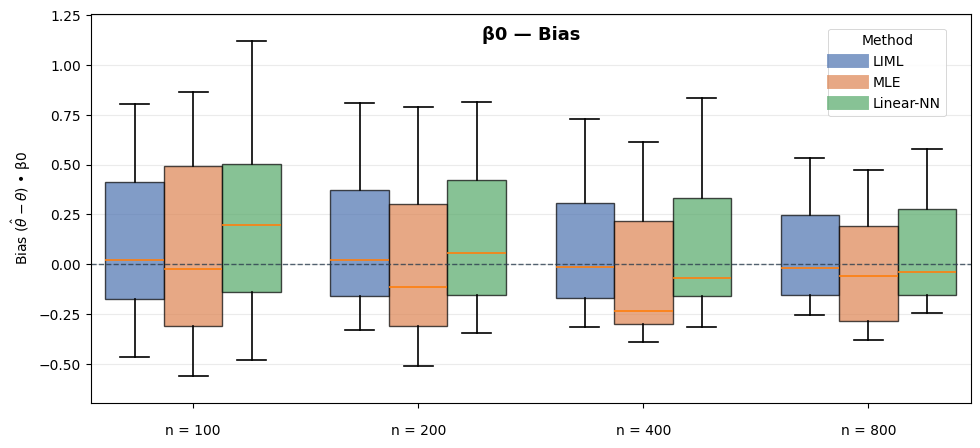

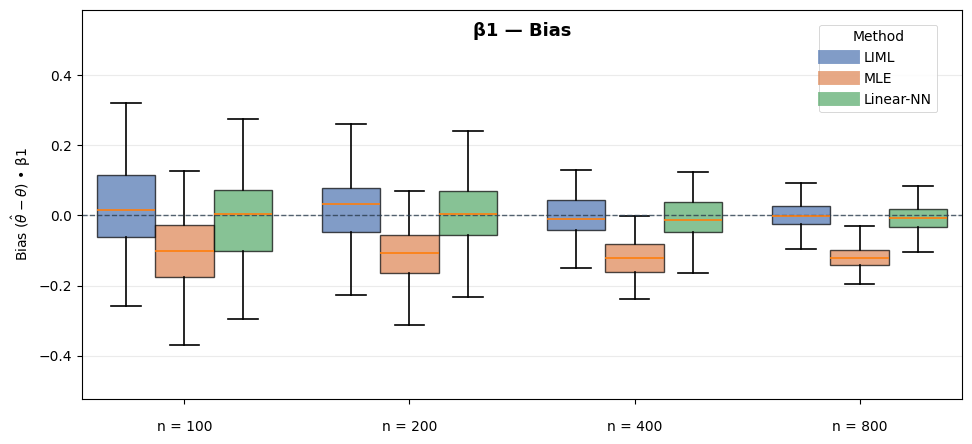

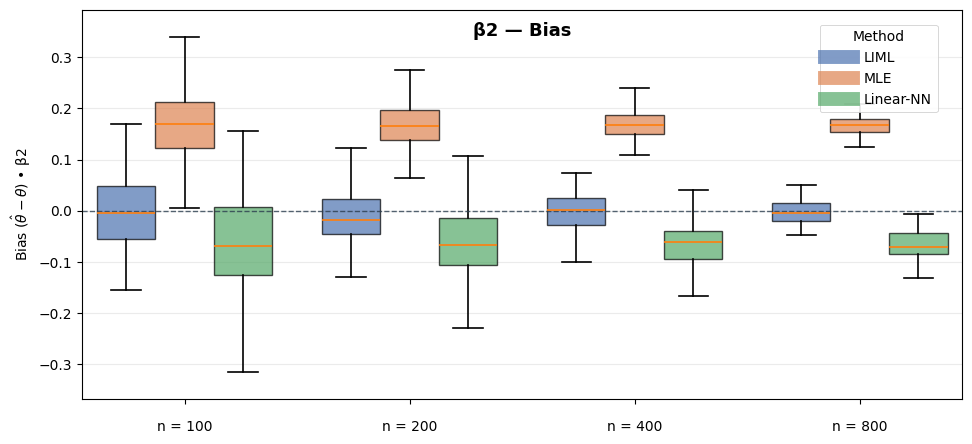

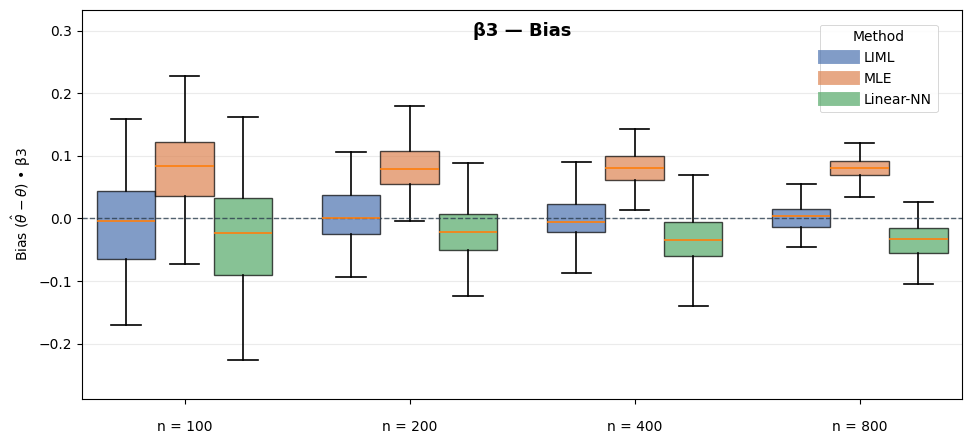

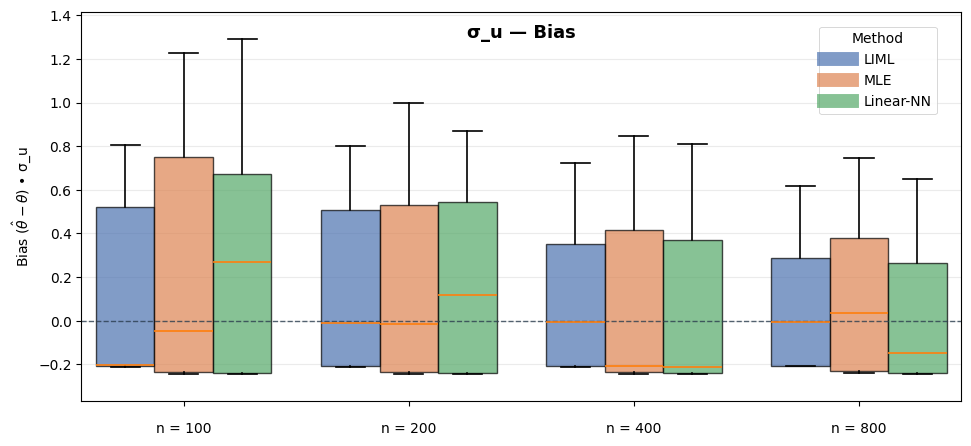

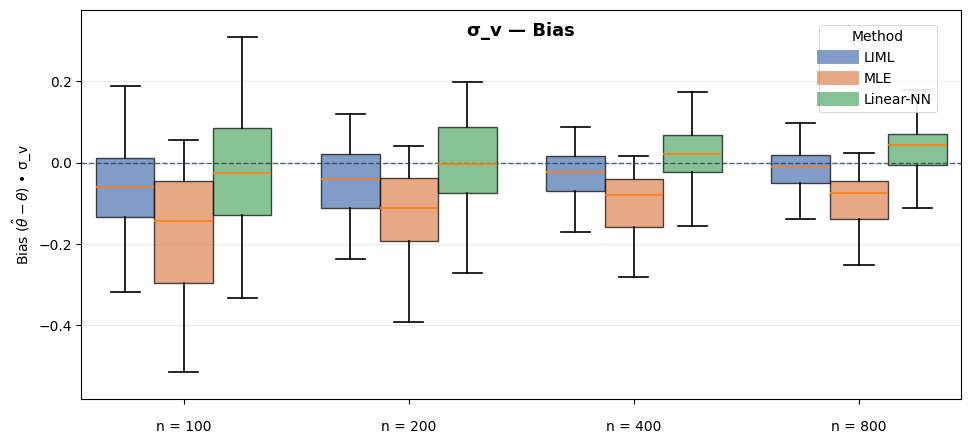

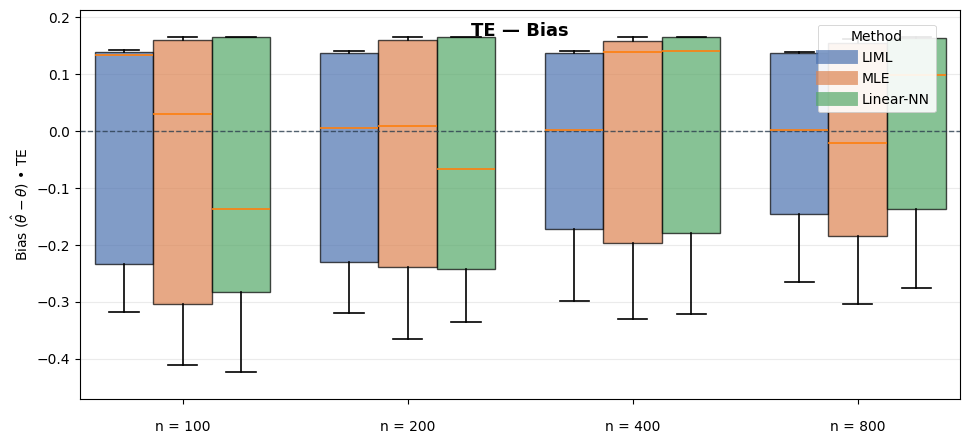

In [1]:
# ================================================================
# Linear comparison: LIML, MLE, Linear-NN  (Bias-only plots fixed)
# - NUM_SIMS=20, NS=(100,200,400) for speed
# - Bias-only boxplots fully inside axes (no clipping)
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from dataclasses import dataclass
from typing import Tuple, Optional, Dict, Any

from scipy.stats import norm, halfnorm
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --------------------------- Globals ---------------------------
BASE_SEED = 12345
np.random.seed(BASE_SEED)
torch.manual_seed(BASE_SEED)
pd.set_option('display.float_format', '{:.4f}'.format)

PARAMS = ['β0','β1','β2','β3','σ_u','σ_v','TE']
TRUE_SIGMA_U = 0.25
TRUE_SIGMA_V = 1.0
NS = (100, 200, 400, 800)         
NUM_SIMS = 100        

METHODS = ('LIML', 'MLE', 'Linear-NN')
COLORS  = {'LIML': '#4C72B0', 'MLE': '#DD8452', 'Linear-NN': '#55A868'}

# --------------------------- Utilities & DGP --------------------
def fill_lower_triangular_columnwise(matrix, values):
    val_index = 0
    for j in range(matrix.shape[1]):
        for i in range(j, matrix.shape[0]):
            if val_index < len(values):
                matrix[i, j] = values[val_index]
                val_index += 1
    return matrix

def make_spd_from_symmetric(A: np.ndarray, jitter: float = 1e-8) -> np.ndarray:
    A = 0.5*(A + A.T)
    try:
        cho_factor(A, lower=False, check_finite=False)
        return A
    except Exception:
        bump = max(jitter, 1e-6*(1.0 + float(np.max(np.abs(np.diag(A))) if A.size else 0.0)))
        while True:
            A_try = A + bump*np.eye(A.shape[0])
            try:
                cho_factor(A_try, lower=False, check_finite=False)
                return A_try
            except Exception:
                bump *= 10.0

def kfold_indices(n: int, K: int, seed: int = 12345):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, K)
    for k in range(K):
        te = folds[k]
        tr = np.hstack([folds[j] for j in range(K) if j != k])
        yield tr, te

def te_from_r_sigma(r: np.ndarray, sigma_u: float, sigma_c: float) -> np.ndarray:
    sigma2 = sigma_u**2 + sigma_c**2
    mu_star = -r * (sigma_u**2) / sigma2
    sigma_star = (sigma_u * sigma_c) / np.sqrt(sigma2)
    a = mu_star / (sigma_star + 1e-15)
    log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
    return np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)

def mean_TE_halfnormal(sigma_u: float) -> float:
    return 2.0 * np.exp(sigma_u**2 / 2.0) * norm.cdf(-sigma_u)

def simulate_dataset(n: int, seed: int,
                     beta_true=np.array([2.0, 1.0, 0.5, 0.8]),
                     sigma_u_true=TRUE_SIGMA_U,
                     Sigma_true=np.array([[1.0, 0.5, 0.3],
                                          [0.5, 1.0, 0.4],
                                          [0.3, 0.4, 1.0]]),
                     Pi_true=np.array([[0.6,  0.2],
                                       [0.9, -0.4],
                                       [1.1,  0.8],
                                       [-0.7, 1.0],
                                       [0.4, -0.8]])):
    rng = np.random.default_rng(seed)
    X1 = rng.normal(size=(n, 1))
    W  = rng.normal(size=(n, 3))
    Z  = np.hstack([np.ones((n,1)), X1, W])   # (n x 5)

    v_eta = rng.multivariate_normal(np.zeros(3), Sigma_true, size=n)
    v, eta = v_eta[:,0], v_eta[:,1:]
    X2 = Z @ Pi_true + eta     # two endogenous regressors

    u = halfnorm.rvs(scale=sigma_u_true, size=n, random_state=seed)
    eps = v - u

    X = np.hstack([np.ones((n,1)), X1, X2])   # [1, X1, X21, X22]
    y = X @ beta_true + eps
    return y, X, Z

# --------------------------- Traditional LIML ------------------
def lnL2_vec(sigee, etas):
    cF = cho_factor(sigee, lower=False, check_finite=False)
    U = cF[0]
    logdet = 2.0 * np.sum(np.log(np.diag(U)))
    x = cho_solve(cF, etas.T, check_finite=False).T
    quad = np.einsum('ij,ij->i', etas, x)
    return -0.5 * logdet - 0.5 * quad

def lnL1_vec(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas):
    sigee = make_spd_from_symmetric(sigee)
    cF = cho_factor(sigee, lower=False, check_finite=False)
    sig_ev = np.asarray(sig_ev).reshape(-1)
    w = cho_solve(cF, sig_ev, check_finite=False)
    muci = etas @ w
    r = y - X @ beta - muci

    sigma_v = np.exp(log_sigma_v)
    correction = float(np.dot(sig_ev, w))
    sigma_c2 = sigma_v**2 - correction
    if sigma_c2 <= 1e-12:
        return np.full(y.shape[0], -1e20)
    sigma_c = np.sqrt(sigma_c2)
    lam_c   = np.exp(log_lambda_c)
    sigma_u = lam_c * sigma_c

    sigma2 = sigma_c2 + sigma_u**2
    sigma  = np.sqrt(sigma2)
    z = -(lam_c / sigma) * r
    lPhi = norm.logcdf(z)
    return -0.5 * np.log(sigma2) - 0.5 * (r**2 / sigma2) + lPhi

def AppLogDen_LIML(coefs, y, X, Z):
    nX, nZ = X.shape[1], Z.shape[1]
    beta = coefs[:nX]
    p1   = coefs[nX : nX + nZ]
    p2   = coefs[nX + nZ : nX + 2*nZ]
    sig_ev = coefs[nX + 2*nZ : nX + 2*nZ + 2]
    sigee_arr = coefs[nX + 2*nZ + 2 : -2]
    log_sigma_v  = coefs[-2]
    log_lambda_c = coefs[-1]

    sigee = fill_lower_triangular_columnwise(np.zeros((2,2)), sigee_arr)
    sigee = make_spd_from_symmetric(sigee + sigee.T - np.diag(np.diag(sigee)))

    z1 = Z @ p1.reshape(-1, 1)
    z2 = Z @ p2.reshape(-1, 1)
    etas = X[:, [2, 3]] - np.hstack([z1, z2])

    l1 = lnL1_vec(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas)
    l2 = lnL2_vec(sigee, etas)
    return l1 + l2

def AppLoglikelihood_LIML(coefs, y, X, Z):
    return -np.sum(AppLogDen_LIML(coefs, y, X, Z))

def AppEstimate_LIML(y, X, Z):
    nX, nZ = X.shape[1], Z.shape[1]
    beta0 = np.linalg.lstsq(X, y, rcond=1e-8)[0]
    P = np.linalg.lstsq(Z, X[:,2:4], rcond=1e-8)[0]
    p1_0, p2_0 = P[:,0], P[:,1]
    etas0 = X[:,2:4] - Z @ P
    sigee0 = make_spd_from_symmetric(np.cov(etas0, rowvar=False))
    s11, s22, s21 = sigee0[0,0], sigee0[1,1], sigee0[1,0]
    sig_ev0 = np.linalg.lstsq(etas0, (y - X @ beta0), rcond=1e-8)[0]
    log_sigma_v0  = np.log(max(np.std(y - X @ beta0), 0.8))
    log_lambda_c0 = np.log(0.30)

    theta0 = np.concatenate([beta0, p1_0, p2_0, sig_ev0, np.array([s11, s21, s22]),
                             np.array([log_sigma_v0, log_lambda_c0])])

    bounds = [(None,None)]*len(beta0) + \
             [(None,None)]*(2*nZ) + \
             [(-5,5)]*2 + \
             [(-5,5)]*3 + \
             [(np.log(0.5), np.log(3.0)), (np.log(0.05), np.log(1.5))]

    res = minimize(
        AppLoglikelihood_LIML, theta0, args=(y, X, Z),
        method='L-BFGS-B', bounds=bounds, options={"maxiter": 3000, "ftol": 1e-9}
    )
    return res.x, res.success

def liml_unpack_for_te(liml_est, y, X, Z):
    nX, nZ = X.shape[1], Z.shape[1]
    beta_hat = liml_est[:nX]
    p1_hat   = liml_est[nX : nX + nZ]
    p2_hat   = liml_est[nX + nZ : nX + 2*nZ]
    sig_ev_hat = liml_est[nX + 2*nZ : nX + 2*nZ + 2]
    sigee_arr  = liml_est[nX + 2*nZ + 2 : -2]
    log_sigma_v = liml_est[-2]
    log_lambda_c = liml_est[-1]

    sigee = fill_lower_triangular_columnwise(np.zeros((2, 2)), sigee_arr)
    sigee = make_spd_from_symmetric(sigee + sigee.T - np.diag(np.diag(sigee)))
    cF = cho_factor(sigee, lower=False, check_finite=False)

    z1_hat = Z @ p1_hat.reshape(-1, 1)
    z2_hat = Z @ p2_hat.reshape(-1, 1)
    etas_hat = X[:, [2, 3]] - np.hstack([z1_hat, z2_hat])

    w = cho_solve(cF, sig_ev_hat, check_finite=False)
    mu_ci = etas_hat @ w

    sigma_v_hat = np.exp(log_sigma_v)
    correction  = float(np.dot(sig_ev_hat, w))
    sigma_c2_hat = sigma_v_hat**2 - correction
    sigma_c_hat  = np.sqrt(max(sigma_c2_hat, 1e-15))
    lambda_c_hat = np.exp(log_lambda_c)
    sigma_u_hat  = lambda_c_hat * sigma_c_hat
    return beta_hat, sigma_u_hat, sigma_v_hat, sigma_c_hat, mu_ci

# --------------------------- Baseline MLE ----------------------
def lnL_MLE(coefs, y, X):
    beta = coefs[:-2]
    sigma_u = np.exp(coefs[-2])
    sigma_v = np.exp(coefs[-1])
    sigma2 = sigma_u**2 + sigma_v**2
    eps = y - X @ beta
    eps_sigma = eps / np.sqrt(sigma2)
    term1 = np.log(2.0 / np.sqrt(sigma2))
    term2 = norm.logpdf(eps_sigma)
    term3 = norm.logcdf(-(sigma_u/sigma_v) * eps_sigma)
    return -np.sum(term1 + term2 + term3)

def AppEstimate_MLE(y, X):
    beta0 = np.linalg.lstsq(X, y, rcond=1e-8)[0]
    resid = y - X @ beta0
    s2 = np.var(resid)
    sigma_u0 = np.sqrt(max(s2/2, 0.05))
    sigma_v0 = np.sqrt(max(s2/2, 0.05))
    bounds = [(None,None)]*len(beta0) + [(-5,5), (-5,5)]
    theta0 = np.concatenate([beta0, [np.log(sigma_u0)], [np.log(sigma_v0)]])
    res = minimize(lnL_MLE, theta0, args=(y, X), method='L-BFGS-B', bounds=bounds,
                   options={'maxiter': 2000, 'ftol': 1e-9})
    if not res.success:
        theta0 = np.concatenate([beta0, [np.log(0.2)], [np.log(1.0)]])
        res = minimize(lnL_MLE, theta0, args=(y, X), method='L-BFGS-B', bounds=bounds)
    theta = res.x
    return np.concatenate([theta[:-2], [np.exp(theta[-2]), np.exp(theta[-1])]])

def estimate_TE_from_theta(y, X, beta, sigma_u, sigma_c):
    r = y - X @ beta
    return te_from_r_sigma(r, sigma_u, sigma_c)

# --------------------------- Linear-NN (NN L2 + LIML L1) ------
@dataclass
class NNConfig:
    epochs: int = 200
    batch_size: int = 32
    lr: float = 1e-3
    weight_decay: float = 1e-4
    hidden: Tuple[int, ...] = (32, 16)
    dropout: float = 0.3
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = BASE_SEED
    K: int = 5

class RF_NN(nn.Module):
    def __init__(self, z_dim: int, k2: int, hidden=(32,16), dropout=0.3):
        super().__init__()
        layers = []
        prev = z_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, k2)]
        self.mlp = nn.Sequential(*layers)
        self.Lpar = nn.Parameter(torch.randn(k2, k2) * 0.1)
        with torch.no_grad():
            for i in range(k2):
                self.Lpar[i, i] = 0.0

    def _Sigma(self):
        L = torch.tril(self.Lpar)
        d = F.softplus(torch.clamp(torch.diag(L), -6.0, 6.0)) + 1e-3
        L = L - torch.diag(torch.diag(L)) + torch.diag(d)
        return L @ L.T, L

    def nll(self, Zb, X2b):
        X2_hat = self.mlp(Zb)
        resid = X2b - X2_hat
        Sigma, L = self._Sigma()
        Y = torch.linalg.solve_triangular(L, resid.T, upper=False)
        quad = (Y**2).sum()
        logdet = 2.0 * torch.log(torch.clamp(torch.diag(L), min=1e-6)).sum()
        m = resid.shape[0]
        reg = 1e-3 * torch.norm(self.Lpar)**2
        return 0.5 * (quad + m * logdet) + reg

def standardize_fit(X: np.ndarray):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd = np.where(sd < 1e-8, 1.0, sd)
    return (X - mu)/sd, mu, sd

def standardize_apply(X: np.ndarray, mu: np.ndarray, sd: np.ndarray):
    return (X - mu)/sd

def crossfit_nn_l2(Z: np.ndarray, X2: np.ndarray, cfg: NNConfig):
    n, _ = Z.shape
    k2 = X2.shape[1]
    eta_hat = np.zeros((n, k2), dtype=np.float64)
    for (tr, te) in kfold_indices(n, cfg.K, seed=cfg.seed):
        Ztr, mu, sd = standardize_fit(Z[tr])
        Zte = standardize_apply(Z[te], mu, sd)
        ntr = Ztr.shape[0]
        nva = max(10, int(0.15*ntr))
        va_idx = np.arange(ntr)[:nva]
        tr_idx = np.arange(ntr)[nva:]

        device = torch.device(cfg.device)
        Ztr_t = torch.tensor(Ztr[tr_idx], dtype=torch.float32, device=device)
        X2tr_t = torch.tensor(X2[tr][tr_idx], dtype=torch.float32, device=device)
        Zva_t = torch.tensor(Ztr[va_idx], dtype=torch.float32, device=device)
        X2va_t = torch.tensor(X2[tr][va_idx], dtype=torch.float32, device=device)

        model = RF_NN(Ztr.shape[1], X2.shape[1], cfg.hidden, cfg.dropout).to(device)
        opt = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        best = np.inf
        best_state = None
        patience, wait = 40, 0
        steps = max(1, Ztr_t.shape[0] // cfg.batch_size)

        for epoch in range(cfg.epochs):
            model.train()
            perm = torch.randperm(Ztr_t.shape[0], device=device)
            for s in range(steps):
                si = s * cfg.batch_size
                ei = min((s+1) * cfg.batch_size, Ztr_t.shape[0])
                if si >= ei: break
                idx = perm[si:ei]
                loss = model.nll(Ztr_t[idx], X2tr_t[idx])
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()

            model.eval()
            with torch.no_grad():
                val_loss = model.nll(Zva_t, X2va_t).item()
            if val_loss < best - 1e-6:
                best = val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
            if wait >= patience:
                break

        if best_state is not None:
            model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            Zte_t = torch.tensor(Zte, dtype=torch.float32, device=device)
            X2_hat_te = model.mlp(Zte_t).cpu().numpy()
        eta_hat[te] = X2[te] - X2_hat_te

    Sigma_hat = np.cov(eta_hat, rowvar=False)
    Sigma_hat = make_spd_from_symmetric(Sigma_hat, jitter=1e-8)
    return eta_hat, Sigma_hat

def lnL1_vec_fixed_sigee(beta: np.ndarray, sig_ev: np.ndarray, sigee: np.ndarray,
                         log_sigma_v: float, log_lambda_c: float,
                         y: np.ndarray, X: np.ndarray, etas: np.ndarray) -> np.ndarray:
    sigee = make_spd_from_symmetric(sigee, jitter=1e-10)
    cF = cho_factor(sigee, lower=False, check_finite=False)
    w = cho_solve(cF, sig_ev, check_finite=False)
    muci = etas @ w
    r = y - X @ beta - muci

    sigma_v = np.exp(log_sigma_v)
    lam_c   = np.exp(log_lambda_c)
    correction = float(sig_ev @ w)
    sigma_c2 = sigma_v**2 - correction
    if sigma_c2 <= 1e-12:
        return np.full(y.shape[0], -1e20)
    sigma_c = np.sqrt(sigma_c2)
    sigma2  = sigma_c2 + (lam_c * sigma_c)**2
    sigma   = np.sqrt(sigma2)
    z = -(lam_c / sigma) * r
    z = np.clip(z, -10, 10)
    lPhi = norm.logcdf(z)
    return -0.5 * np.log(sigma2) - 0.5 * (r**2 / sigma2) + lPhi

def neg_loglik_L1_only(theta: np.ndarray, y: np.ndarray, X: np.ndarray,
                       etas: np.ndarray, sigee: np.ndarray, k2: int) -> float:
    p = X.shape[1]
    beta = theta[:p]
    sig_ev = theta[p:p+k2]
    log_sigma_v = theta[-2]
    log_lambda_c = theta[-1]
    l1 = lnL1_vec_fixed_sigee(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas)
    val = -float(np.sum(l1))
    return 1e10 if not np.isfinite(val) else val

def estimate_LIML_L1_only(y: np.ndarray, X: np.ndarray, etas: np.ndarray, sigee: np.ndarray,
                          fallback: bool = True) -> Dict[str, Any]:
    n, p = X.shape
    k2   = etas.shape[1]
    beta0 = np.linalg.lstsq(X, y, rcond=1e-8)[0]
    e0 = y - X @ beta0
    try:
        sig_ev0 = np.linalg.lstsq(etas, e0, rcond=1e-8)[0]
    except np.linalg.LinAlgError:
        sig_ev0 = np.zeros(k2)
    log_sigma_v0 = np.log(max(np.std(e0), 0.6))
    log_lambda_c0 = np.log(0.5)
    theta0 = np.concatenate([beta0, sig_ev0, [log_sigma_v0, log_lambda_c0]])
    lower = [-np.inf]*p + [-np.inf]*k2 + [np.log(0.01), np.log(0.01)]
    upper = [ np.inf]*p + [ np.inf]*k2 + [np.log(10.0), np.log(10.0)]
    bounds = list(zip(lower, upper))
    methods = ['L-BFGS-B'] + (['SLSQP'] if fallback else [])
    best_res, best_fun = None, np.inf
    for m in methods:
        try:
            res = minimize(neg_loglik_L1_only, theta0,
                           args=(y, X, etas, sigee, k2),
                           method=m, bounds=bounds,
                           options={'maxiter': 5000, 'ftol': 1e-9})
            if res.fun < best_fun:
                best_res, best_fun = res, res.fun
        except Exception as e:
            warnings.warn(f"LIML optimization failed with {m}: {e}")
    if best_res is None:
        raise RuntimeError("All optimization attempts failed.")
    theta = best_res.x
    beta_hat = theta[:p]
    sig_ev_hat = theta[p:p+k2]
    log_sigma_v = theta[-2]
    log_lambda_c = theta[-1]
    cF = cho_factor(sigee, lower=False, check_finite=False)
    w = cho_solve(cF, sig_ev_hat, check_finite=False)
    correction = float(sig_ev_hat @ w)
    sigma_v_hat = float(np.exp(log_sigma_v))
    sigma_c2_hat = sigma_v_hat**2 - correction
    sigma_c_hat = float(np.sqrt(max(sigma_c2_hat, 1e-15)))
    lambda_c_hat = float(np.exp(log_lambda_c))
    sigma_u_hat = float(lambda_c_hat * sigma_c_hat)
    return {
        'success': best_res.success,
        'message': best_res.message,
        'beta': beta_hat,
        'sig_ev': sig_ev_hat,
        'sigma_v': sigma_v_hat,
        'sigma_c': sigma_c_hat,
        'sigma_u': sigma_u_hat,
        'lambda_c': lambda_c_hat,
        'w': w
    }

def linear_nn_estimate_with_te(y, X, Z, nn_cfg=None):
    if nn_cfg is None:
        nn_cfg = NNConfig()
    X2 = X[:, 2:4]
    eta_hat, Sigma_hat = crossfit_nn_l2(Z, X2, nn_cfg)
    liml = estimate_LIML_L1_only(y, X, eta_hat, Sigma_hat, fallback=True)
    if not liml.get('success', True):
        return [np.nan]*7
    muci = eta_hat @ liml['w']
    r = y - X @ liml['beta'] - muci
    te = te_from_r_sigma(r, sigma_u=liml['sigma_u'], sigma_c=liml['sigma_c'])
    te_mean = float(np.mean(te))
    return list(liml['beta'][:4]) + [float(liml['sigma_u']), float(liml['sigma_v']), te_mean]

# --------------------------- Collect simulations ---------------
def collect_per_sim_linear(num_sims=NUM_SIMS, n=400, nn_cfg=None):
    rows = []
    true_map = {'β0':2.0,'β1':1.0,'β2':0.5,'β3':0.8,'σ_u':TRUE_SIGMA_U,'σ_v':TRUE_SIGMA_V,'TE':mean_TE_halfnormal(TRUE_SIGMA_U)}

    for sim in range(num_sims):
        seed = BASE_SEED + 1000*n + sim
        y, X, Z = simulate_dataset(n, seed=seed)

        # LIML
        liml_vals = [np.nan]*len(PARAMS)
        try:
            liml_est, ok = AppEstimate_LIML(y, X, Z)
            if ok:
                beta_hat, sig_u_hat, sig_v_hat, sig_c_hat, mu_ci = liml_unpack_for_te(liml_est, y, X, Z)
                r = y - X @ beta_hat - mu_ci
                te_liml = te_from_r_sigma(r, sig_u_hat, sig_c_hat)
                liml_vals = list(beta_hat[:4]) + [float(sig_u_hat), float(sig_v_hat), float(np.mean(te_liml))]
        except Exception:
            pass

        # MLE
        mle_vals = [np.nan]*len(PARAMS)
        try:
            mle_est = AppEstimate_MLE(y, X)  # [β..., σ_u, σ_v]
            te_mle = estimate_TE_from_theta(y, X, mle_est[:4], mle_est[4], mle_est[5])
            mle_vals = mle_est.tolist() + [float(np.mean(te_mle))]
        except Exception:
            pass

        # Linear-NN
        nn_vals = [np.nan]*len(PARAMS)
        try:
            nn_vals = linear_nn_estimate_with_te(y, X, Z, nn_cfg=nn_cfg)
        except Exception:
            pass

        est_by_method = {'LIML': liml_vals, 'MLE': mle_vals, 'Linear-NN': nn_vals}
        for method in METHODS:
            for p, est_val in zip(PARAMS, est_by_method[method]):
                t = float(true_map[p])
                if np.isfinite(est_val):
                    b = float(est_val) - t
                    rows.append({'n': n, 'sim': sim, 'method': method, 'param': p,
                                 'estimate': float(est_val), 'true': t,
                                 'bias': b, 'abs_error': abs(b)})
                else:
                    rows.append({'n': n, 'sim': sim, 'method': method, 'param': p,
                                 'estimate': np.nan, 'true': t,
                                 'bias': np.nan, 'abs_error': np.nan})
    return pd.DataFrame(rows)

def run_all_simulations(ns=NS, num_sims=NUM_SIMS, nn_cfg=None):
    dfs = []
    for n in ns:
        print(f"Running simulations for n = {n} ...")
        dfs.append(collect_per_sim_linear(num_sims=num_sims, n=n, nn_cfg=nn_cfg))
    all_df = pd.concat(dfs, ignore_index=True)
    print("✅ All simulations completed.")
    return all_df

# --------------------------- Reporting -------------------------
def _method_summary_from_long(df_n_method: pd.DataFrame) -> pd.DataFrame:
    method = df_n_method['method'].iloc[0]
    rows = []
    for p in PARAMS:
        d = df_n_method[df_n_method['param'] == p]
        true_val = d['true'].iloc[0]
        est = d['estimate'].to_numpy()
        diff = est - true_val
        mean_est = np.nanmean(est)
        bias = np.nanmean(np.abs(diff))   # MAE
        rmse = np.sqrt(np.nanmean(diff**2))
        rows.append([p, true_val, mean_est, bias, rmse])
    tbl = pd.DataFrame(rows, columns=['Parameter','True Value',
                                      f'{method}_Mean', f'{method}_Bias', f'{method}_RMSE'])
    return tbl.set_index('Parameter')

def print_results_by_n_side_by_side(df_all: pd.DataFrame, ns=NS,
                                    methods=METHODS, save_dir: str=None):
    for n in ns:
        df_n = df_all[df_all['n'] == n]
        if df_n.empty:
            continue
        method_tables = []
        for m in methods:
            df_nm = df_n[df_n['method'] == m]
            if df_nm.empty:
                continue
            method_tables.append(_method_summary_from_long(df_nm))
        out = method_tables[0].copy()
        for t in method_tables[1:]:
            out = out.join(t.drop(columns=['True Value']), how='left')

        print(f"\n=== Linear Simulation Results (n={n}, num_sims={df_n['sim'].nunique()}) ===")
        print(out.round(4))
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            out.to_csv(f"{save_dir}/linear_results_n{n}.csv")

# --------------------------- Bias-only plot (inside axes) ------
def boxplot_bias_only_grouped_by_n(
    df,
    params=('β0','β1','β2','β3','σ_u','σ_v','TE'),
    ns_sorted=None,
    methods=METHODS,
    colors=COLORS
):
    """
    Bias-only boxplots with everything *inside* the plot area.
    We:
      - compute y-lims from the actual data ranges across all boxes (whiskers),
      - enforce x-lims from exact positions + width,
      - draw title and legend inside the axes.
    """
    if ns_sorted is None:
        ns_sorted = sorted(df['n'].unique())

    n_groups  = len(ns_sorted)
    n_methods = len(methods)
    group_w   = 0.78
    box_w     = group_w / n_methods
    offsets   = np.linspace(-group_w/2 + box_w/2,
                            group_w/2 - box_w/2,
                            n_methods)
    x_centers = np.arange(n_groups)

    for p in params:
        dparam = df[df['param'] == p].copy()
        fig, ax = plt.subplots(figsize=(10, 4.8))
        fig.subplots_adjust(left=0.10, right=0.98, top=0.95, bottom=0.14)

        # Build all groups once to compute y-range robustly (whiskers use min/max)
        all_pos = []
        global_min, global_max = np.inf, -np.inf
        cache = {}

        for mi, m in enumerate(methods):
            data = [dparam[(dparam['n'] == n) & (dparam['method'] == m)]['bias'].values
                    for n in ns_sorted]
            pos = x_centers + offsets[mi]
            all_pos.extend(pos.tolist())
            cache[m] = (data, pos)

            for arr in data:
                if arr.size:
                    vmin = np.nanmin(arr)
                    vmax = np.nanmax(arr)
                    global_min = min(global_min, vmin)
                    global_max = max(global_max, vmax)

        # Set y-limits using actual min/max + padding
        if np.isfinite(global_min) and np.isfinite(global_max):
            yr = global_max - global_min
            pad = 0.08 * (yr if yr > 0 else 1.0)
            ax.set_ylim(global_min - pad, global_max + pad)

        # Draw boxes
        for mi, m in enumerate(methods):
            data, pos = cache[m]
            bp = ax.boxplot(
                data, positions=pos, widths=box_w,
                showfliers=False, patch_artist=True
            )
            for patch in bp['boxes']:
                patch.set_facecolor(colors[m]); patch.set_alpha(0.70)
            for k in ('whiskers','caps','medians'):
                for artist in bp[k]:
                    artist.set_linewidth(1.2)

        # Exact x-limits from positions
        xmin = min(all_pos) - 0.75*box_w
        xmax = max(all_pos) + 0.75*box_w
        ax.set_xlim(xmin, xmax)

        ax.set_xticks(x_centers)
        ax.set_xticklabels([f"n = {n}" for n in ns_sorted])
        for tick in ax.get_xticklabels():
            tick.set_y(-0.03)  # pull tick labels inside a bit

        ax.axhline(0, lw=1, ls='--', color='#2C3E50', alpha=0.8)
        ax.text(0.5, 0.97, f"{p} — Bias", transform=ax.transAxes,
                ha='center', va='top', fontsize=13, fontweight='bold')

        handles = [plt.Line2D([0],[0], color=colors[m], lw=10, alpha=0.70, label=m)
                   for m in methods]
        leg = ax.legend(handles=handles, title="Method",
                        loc='upper right', bbox_to_anchor=(0.98, 0.98),
                        frameon=True, framealpha=0.9)
        leg.get_frame().set_linewidth(0.6)

        ax.set_ylabel(f"Bias $(\\hat{{\\theta}} - \\theta)$ • {p}")
        ax.grid(True, axis='y', alpha=0.25)
        plt.show()

# --------------------------- Main ------------------------------
if __name__ == "__main__":
    nn_cfg = NNConfig(K=5, epochs=200, batch_size=32, lr=1e-3, dropout=0.3, hidden=(32,16))

    # Run all methods across selected n with reduced sims
    df_all = run_all_simulations(ns=NS, num_sims=NUM_SIMS, nn_cfg=nn_cfg)

    # Print per-n tables
    print_results_by_n_side_by_side(
        df_all,
        ns=NS,
        methods=('LIML','MLE','Linear-NN'),
        save_dir=None  # set to "linear_results" to save CSVs
    )

    # Bias-only figures (everything inside the axes)
    boxplot_bias_only_grouped_by_n(
        df_all,
        params=('β0','β1','β2','β3','σ_u','σ_v','TE'),
        methods=('LIML','MLE','Linear-NN')
    )
